In [61]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



In [62]:
data_path = "/Applications/Work Space/Python Work Space/python_Unet_segmentation/lecture-2/data/Common Carotid Artery Ultrasound Images"

img_path = os.path.join(data_path, "US images")
mask_path = os.path.join(data_path, "Expert mask images") 


In [63]:
image_files = sorted(os.listdir(img_path)) # sorted([img_path+i for i in os.listdir(img_path)])
mask_files = sorted(os.listdir(mask_path)) # sorted([mask_path+i for i in os.listdir(mask_path)])

In [64]:
info_df = pd.DataFrame({"img_path":image_files, "mask_path":mask_files})
info_df

,img_path,mask_path
0,202201121748100022VAS_slice_1069.png,202201121748100022VAS_slice_1069.png
1,202201121748100022VAS_slice_1080.png,202201121748100022VAS_slice_1080.png
2,202201121748100022VAS_slice_1092.png,202201121748100022VAS_slice_1092.png
3,202201121748100022VAS_slice_1108.png,202201121748100022VAS_slice_1108.png
4,202201121748100022VAS_slice_1128.png,202201121748100022VAS_slice_1128.png
...,...,...
1095,202202071359200056VAS_slice_117.png,202202071359200056VAS_slice_117.png
1096,202202071359200056VAS_slice_180.png,202202071359200056VAS_slice_180.png
1097,202202071359200056VAS_slice_214.png,202202071359200056VAS_slice_214.png
1098,202202071359200056VAS_slice_227.png,202202071359200056VAS_slice_227.png


In [65]:
print(info_df.duplicated().sum())
print(info_df.isnull().sum())
print(info_df.columns)
print(info_df.shape)

0
img_path     0
mask_path    0
dtype: int64
Index(['img_path', 'mask_path'], dtype='object')
(1100, 2)


In [66]:
# This unction check the all mak files and image files are metched, otherwise error will be assert.
for img_, msk_ in zip(image_files, mask_files):
    if img_.split(".")[0] == msk_.split(".")[0]:
        continue
    else:
        assert "Mistmach Files!" # Hata fırlatır...



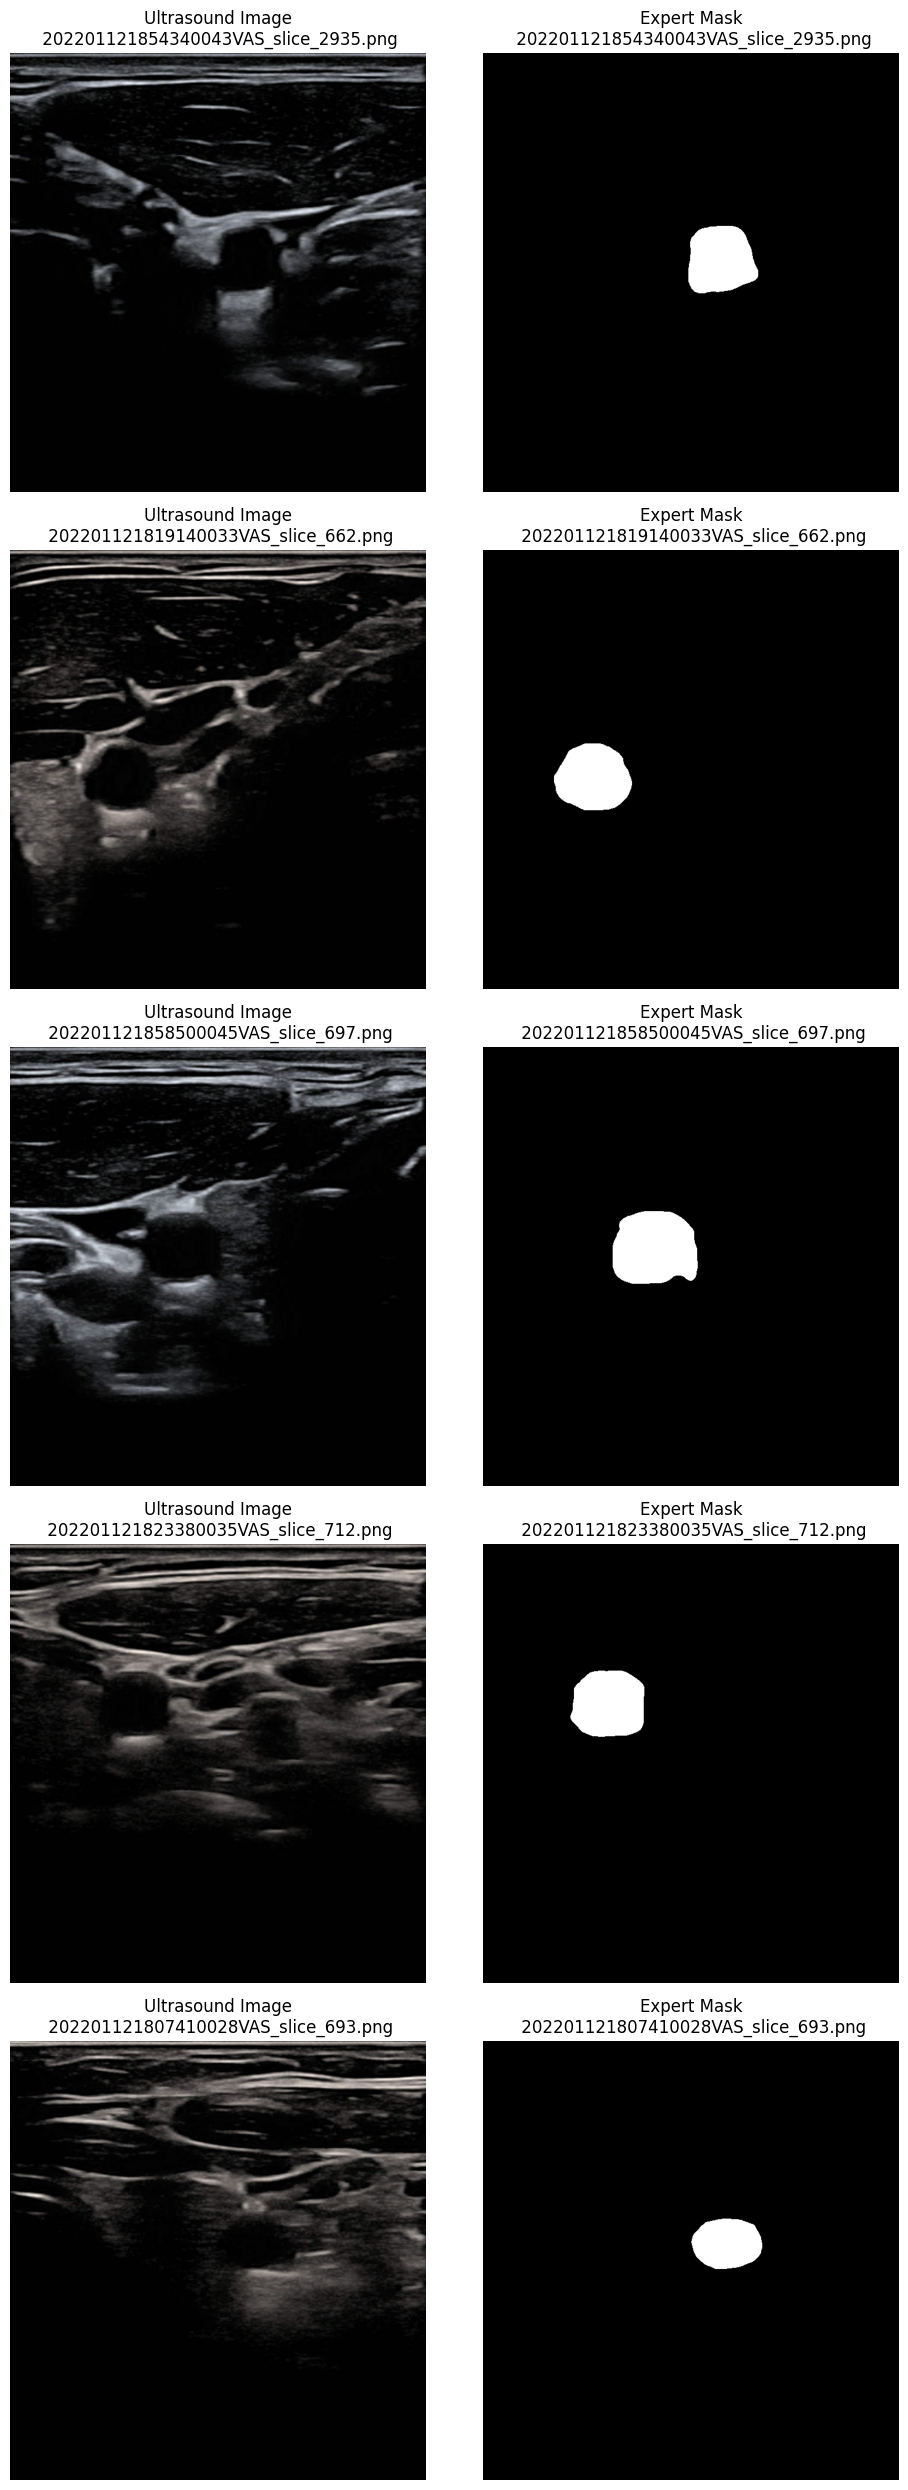

In [67]:
fig, axes = plt.subplots(5,2, figsize=(10,25))

for idx in range(5):
    random_index = random.randint(0, len(image_files)-1)
    img_dir = os.path.join(img_path, image_files[random_index]) 
    mask_dir = os.path.join(mask_path, image_files[random_index]) 

    img = cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE)

    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Ultrasound Image\n {image_files[random_index]}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(mask, cmap="gray")
    axes[idx, 1].set_title(f"Expert Mask\n {image_files[random_index]}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()


    



In [68]:
image_list = [f for f in os.listdir(img_path) if f.endswith(".png")]
mask_list = [f for f in os.listdir(mask_path) if f.endswith(".png")]

In [69]:
missing_masks = [f for f in image_list if f not in mask_list]

if missing_masks:
    raise ValueError(f"missing masks for {len(missing_masks)} images, including: {missing_masks[:3]}")

file_pairs = [(os.path.join(img_path, f), os.path.join(mask_path, f)) for f in image_list]

In [70]:
df = pd.DataFrame(file_pairs, columns=["image_path", "mask_path"])
df.head()

,image_path,mask_path
0,/Applications/Work Space/Python Work Space/pyt...,/Applications/Work Space/Python Work Space/pyt...
1,/Applications/Work Space/Python Work Space/pyt...,/Applications/Work Space/Python Work Space/pyt...
2,/Applications/Work Space/Python Work Space/pyt...,/Applications/Work Space/Python Work Space/pyt...
3,/Applications/Work Space/Python Work Space/pyt...,/Applications/Work Space/Python Work Space/pyt...
4,/Applications/Work Space/Python Work Space/pyt...,/Applications/Work Space/Python Work Space/pyt...


In [71]:
def extract_subjects_id(filename):
    """Extractions Subject ID from filenames
    """

    parts = filename.split("_")

    if len(parts) < 3:
        raise ValueError(f"Unexpected filename format: {filename}")
    
    first_part = parts[0]
    timestamp_length = 18

    if len(first_part) < timestamp_length:
        raise ValueError(f"Unexpected first part lenght: {first_part}")
    
    identifier = first_part[timestamp_length:]
    subject_id = identifier.split()[0].strip()

    return subject_id


In [72]:
df["subject_id"] = df["image_path"].apply(lambda x: extract_subjects_id(os.path.basename(x))) # Burda x imiz bizim df["image_path"] içindeki bilgilerin tek tek verilmesi gibi düşün

print("Unique Subject IDs:" , df["subject_id"].unique())


Unique Subject IDs: ['VAS' 'EM']


In [73]:

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [74]:
def load_data(df, image_size=(256, 256)):
    images = []
    masks = []

    for image_path, mask_path in zip(df["image_path"], df["mask_path"]):
        img = load_img(image_path, target_size=image_size) # PIL.Image.Image
        img = img_to_array(img) / 255.0 # array
        images.append(img)


        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale") # PIL.Image.Image
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    
    return np.array(images), np.array(masks)
        

In [75]:
images, masks = load_data(df)

masks = np.expand_dims(masks, axis=-1)

In [76]:
print(images.shape)
print(masks.shape)

(1100, 256, 256, 3)
(1100, 256, 256, 1, 1)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.2, random_state=42)

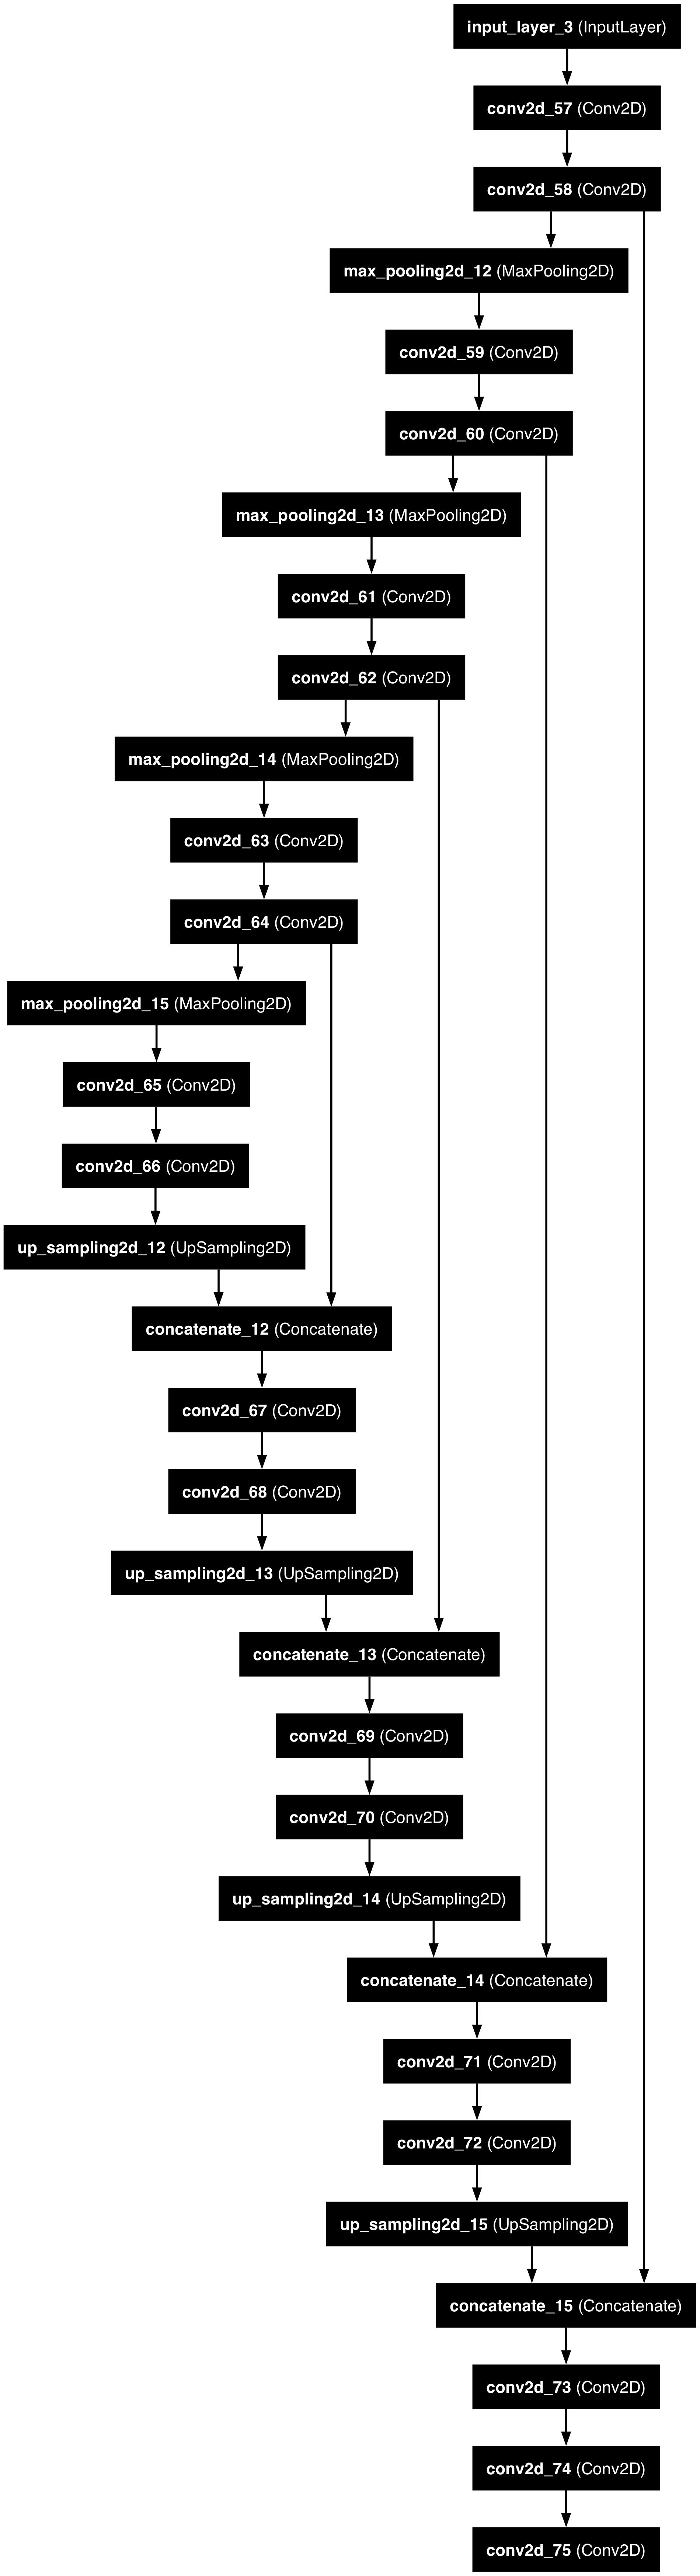

In [78]:
from tensorflow.keras.utils import plot_model 

model = unet()
plot_model(model, to_file="Unet_architecture.png", show_layer_names=True)

# Display image inside notebook (optionale)
from IPython.display import Image
Image("Unet_architecture.png")

In [79]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


early_stopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)

history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    shuffle=True, epochs=15, batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

loss, accuracy = model.evaluate(X_test, y_test)



Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.9284 - loss: 0.2722 - val_accuracy: 0.9761 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.9765 - loss: 0.0923 - val_accuracy: 0.9761 - val_loss: 0.0758 - learning_rate: 0.0010
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.9765 - loss: 0.0693 - val_accuracy: 0.9761 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.9765 - loss: 0.0561 - val_accuracy: 0.9761 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.9765 - loss: 0.0444 - val_accuracy: 0.9761 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9853 - loss: 0.0278 - val_accuracy: 0.9913 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.9925 - loss: 0.0203 - val_accur

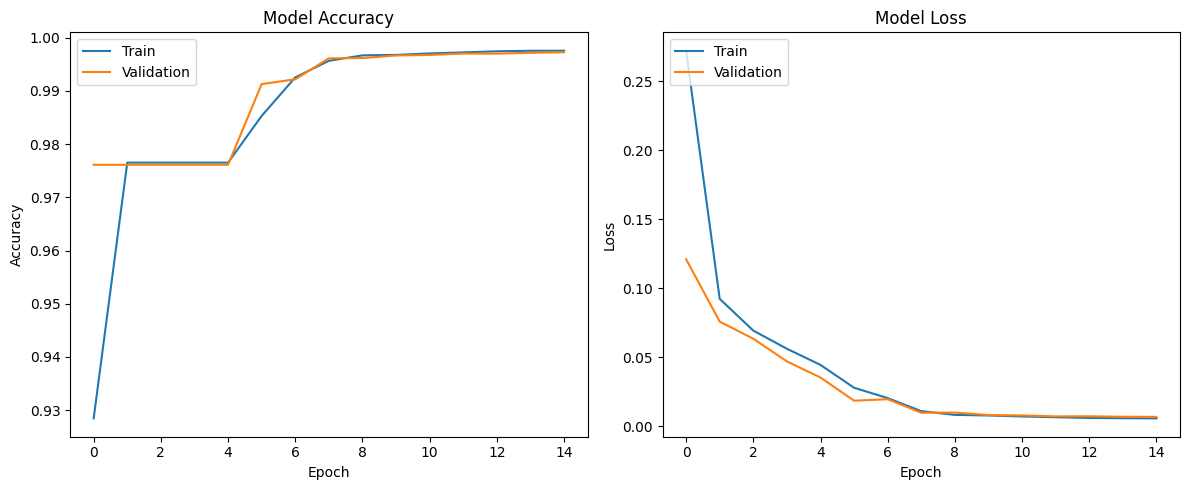

In [80]:
def plot_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"])
    if "val_accuracy" in history.history:
        plt.plot(history.history["val_accuracy"])
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Validation"], loc="upper left")
    else:
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train"], loc="upper left")


    plt.subplot(1,2,2)
    plt.plot(history.history["loss"])
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"])
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Validation"], loc="upper left")
    else:
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train"], loc="upper left")

    plt.tight_layout()
    plt.show()



plot_history(history)

In [81]:
def calculation_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 0.0
    
    return intersection/union

def calculation_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    if total == 0:
        return 0.0
    
    return 2*intersection / total

In [82]:
y_pred_binary = (model.predict(X_test) > 0.15).astype(bool)
y_test_binary = y_test.astype(bool)


iou = calculation_iou(y_test_binary.squeeze(), y_pred_binary.squeeze())
dice = calculation_dice(y_test_binary.squeeze(), y_pred_binary.squeeze())

print(f"IoU: {iou}")
print(f"Dice: {dice}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
IoU: 0.8838623641574671
Dice: 0.9383513158645886


In [83]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_57[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_59[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_61[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_63[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_15… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_65[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 32, 32,    │          0 │ conv2d_66[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 32, 32,    │          0 │ up_sampling2d_12

 Total params: 5,887,877 (22.46 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,925,252 (14.97 MB)

In [84]:
model.save("carotid_artery.keras")

# Test The Models


In [85]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your real test image (change this to our image pth)
real_img_path = ""

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


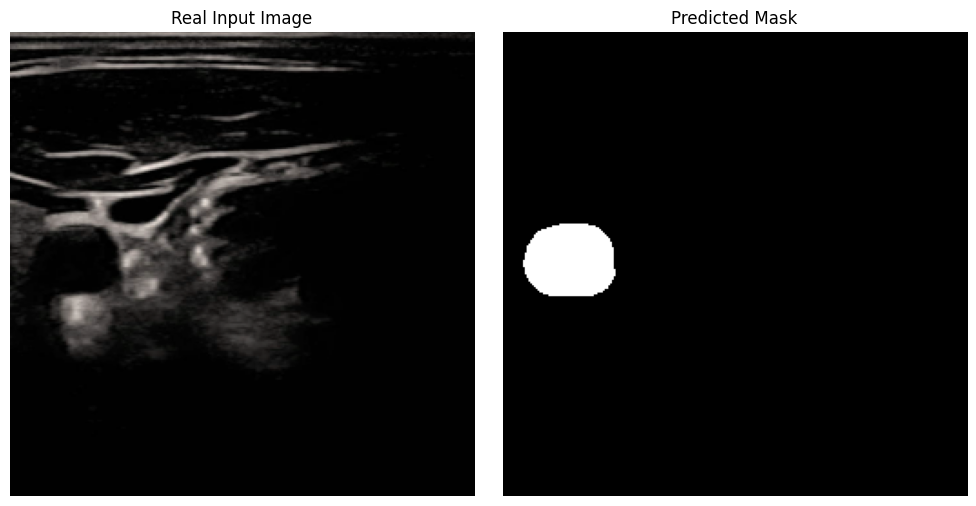

In [86]:
# Path to your real test image (change this to your image path)
real_image_path = "/Applications/Work Space/Python Work Space/python_Unet_segmentation/lecture-2/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_2689.png"  # ← Update as needed

# Preprocess real input image
def preprocess_single_image(img_path, target_size=(256, 256)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Test function for real image
def test_real_image(image_path):
    # Preprocess input image
    input_image = preprocess_single_image(image_path)

    # Predict using trained model
    prediction = model.predict(input_image)[0, :, :, 0]  # Get 2D prediction

    # Load original image for display
    img_show = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img_show = cv2.resize(img_show, (256, 256))

    # Plot original image and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_show)
    plt.title("Real Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction > 0.24, cmap='gray')  # Show binary mask
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔁 Run test
test_real_image(real_image_path)